# 
<h1 style="font-size:300%; color:tomato; font-family:cursive;">Nepali House Price Prediction</h1>

The goal of this project is to learn about data pre-processing, feature engineering, and model building. I will be using the dataset from [Kaggle](https://www.kaggle.com/datasets/sagyamthapa/nepali-housing-price-dataset/data) which i felt is one of the challenging dataset which truly represents real-world noise. This notebook won’t explain the steps I take, as I have prepared a separate notebook for that.









# 1. Data Exploration

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

In [110]:
data = pd.read_csv('2020-4-27.csv') # read data from csv file

In [111]:
data.head(2)

,Title,Address,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Views,Area,Road,Road Width,Road Type,Build Area,Posted,Amenities
0,Flat System House On Sale At Budhanikantha : H...,"Budhanikantha, Budhanilkantha, Kathmandu",Kathmandu,90000000,6,3,2.0,10,West,2073.0,17,1-0-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,18-0-0-0 Aana,11 hours ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
1,21 Aana Beautiful House : House For Sale In Bu...,"Pasikot, Budhanilkantha, Kathmandu",Kathmandu,80000000,5,3,2.0,9,East,2073.0,26,0-21-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-14-0-0 Aana,12 hours ago,"['Parking', 'Garage', 'Fencing', 'Frontyard', ..."


In [112]:
print(f" Columns in dataset: \n{data.columns}. \n Number of columns: {len(data.columns)}")


 Columns in dataset: 
Index(['Title', 'Address', 'City', 'Price', 'Bedroom', 'Bathroom', 'Floors',
       'Parking', 'Face', 'Year', 'Views', 'Area', 'Road', 'Road Width',
       'Road Type', 'Build Area', 'Posted', 'Amenities'],
      dtype='object'). 
 Number of columns: 18


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       2211 non-null   object 
 1   Address     2211 non-null   object 
 2   City        2211 non-null   object 
 3   Price       2211 non-null   int64  
 4   Bedroom     2211 non-null   int64  
 5   Bathroom    2211 non-null   int64  
 6   Floors      1039 non-null   float64
 7   Parking     2211 non-null   int64  
 8   Face        2211 non-null   object 
 9   Year        582 non-null    float64
 10  Views       2211 non-null   object 
 11  Area        2211 non-null   object 
 12  Road        2211 non-null   object 
 13  Road Width  2211 non-null   object 
 14  Road Type   1426 non-null   object 
 15  Build Area  2211 non-null   object 
 16  Posted      2211 non-null   object 
 17  Amenities   2211 non-null   object 
dtypes: float64(2), int64(4), object(12)
memory usage: 311.1+ KB


In [114]:
data.shape # shape of the data

(2211, 18)

In [115]:
data.index # index of the data

RangeIndex(start=0, stop=2211, step=1)

In [116]:
data.isna().sum() # check for missing values

Title            0
Address          0
City             0
Price            0
Bedroom          0
Bathroom         0
Floors        1172
Parking          0
Face             0
Year          1629
Views            0
Area             0
Road             0
Road Width       0
Road Type      785
Build Area       0
Posted           0
Amenities        0
dtype: int64

<Axes: >

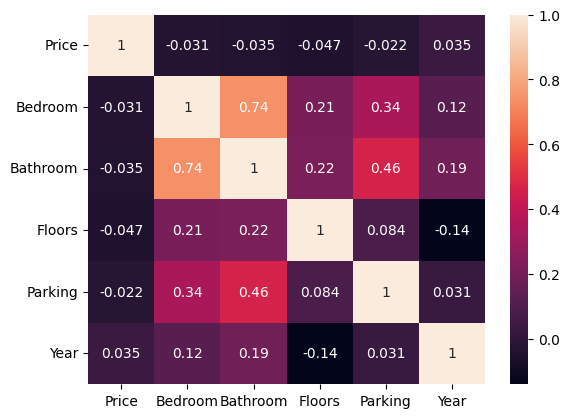

In [117]:
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True) # correlation matrix


In [118]:
data.sort_values("Year", ascending=True).head(3)

,Title,Address,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Views,Area,Road,Road Width,Road Type,Build Area,Posted,Amenities
1607,"Prachanda Chitrakar : Hostel For Rent In Ason,...","Thahity, Ason, Kathmandu",Kathmandu,190000150000,0,0,7.0,3,West,1994.0,352,2 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,5500 Sq. Feet,11 months ago,"['Drainage', 'Water Supply']"
1538,"DT : Office Space For Rent In Jawalakhel, Lali...","Jawalakhel, Lalitpur, Jawalakhel, Lalitpur",Lalitpur,155000150000,0,0,2.0,0,South West,2000.0,301,1-12-0-0 Aana,32 Feet / Blacktopped,32 Feet,Blacktopped,5 Aana,10 months ago,[]
243,House On Sale At Chabahil (50m Towards Ganeshs...,"Chabahil, Charumati bihar, Chabahil, Kathmandu",Kathmandu,25000000,6,4,4.0,2,East,2000.0,479,2.5 Aana,20 Feet / Paved,20 Feet,Paved,2.5 Aana,2 months ago,"['Parking', 'Balcony', 'Drainage', 'Water Supp..."


In [119]:
data[data['Year'].isna() | data['Floors'].isna()][['Year','Floors']] # checking missing values

,Year,Floors
17,NaN,NaN
18,NaN,NaN
19,NaN,NaN
21,NaN,NaN
25,NaN,3.0
...,...,...
2205,NaN,NaN
2206,NaN,3.0
2207,NaN,2.0
2209,NaN,2.0


In [120]:
data['Year'].mean()

np.float64(2057.780068728522)

# 2. Data Cleaning and Transformations

In [121]:
year_constant = data['Year'].mean().round(0)


In [122]:
floor_constant = data['Floors'].mean().round(0) 

## 2.1. Handling Missing Values

In [123]:
#filling missing value of year wiht mean value

data['Year'] = data['Year'].fillna(year_constant)

# filling missing vlue of floor with mean value
data['Floors'] = data['Floors'].fillna(floor_constant)

# handling road type column by dropping it
data.drop('Road Type', axis=1, inplace=True) # droping column

In [124]:
data.isna().sum()

Title         0
Address       0
City          0
Price         0
Bedroom       0
Bathroom      0
Floors        0
Parking       0
Face          0
Year          0
Views         0
Area          0
Road          0
Road Width    0
Build Area    0
Posted        0
Amenities     0
dtype: int64

## 2.2 Dropping Unnecessary Columns

In [125]:
data.head(2)

,Title,Address,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Views,Area,Road,Road Width,Build Area,Posted,Amenities
0,Flat System House On Sale At Budhanikantha : H...,"Budhanikantha, Budhanilkantha, Kathmandu",Kathmandu,90000000,6,3,2.0,10,West,2073.0,17,1-0-0-0 Aana,20 Feet / Blacktopped,20 Feet,18-0-0-0 Aana,11 hours ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
1,21 Aana Beautiful House : House For Sale In Bu...,"Pasikot, Budhanilkantha, Kathmandu",Kathmandu,80000000,5,3,2.0,9,East,2073.0,26,0-21-0-0 Aana,20 Feet / Blacktopped,20 Feet,0-14-0-0 Aana,12 hours ago,"['Parking', 'Garage', 'Fencing', 'Frontyard', ..."


In [126]:
temp = data.pop('Title') # poping out the title column which might be needed for resolving otyher missing values

In [127]:
columns_to_drop = ['Address', 'Views', 'Posted','Road']

In [128]:
data.drop(columns_to_drop, axis=1, inplace=True)

In [129]:
data.head()

,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Area,Road Width,Build Area,Amenities
0,Kathmandu,90000000,6,3,2.0,10,West,2073.0,1-0-0-0 Aana,20 Feet,18-0-0-0 Aana,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
1,Kathmandu,80000000,5,3,2.0,9,East,2073.0,0-21-0-0 Aana,20 Feet,0-14-0-0 Aana,"['Parking', 'Garage', 'Fencing', 'Frontyard', ..."
2,Kathmandu,70000000,5,3,2.0,12,East,2071.0,1-1-0-0 Aana,20 Feet,10-1-0-0 Aana,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
3,Kathmandu,130000000,6,4,3.0,9,West,2017.0,0-10-1-0 Aana,20 Feet,0-7-1-0 Aana,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
4,Kathmandu,100000000,6,3,2.0,10,East,2070.0,0-19-2-0 Aana,20 Feet,0-14-2-0 Aana,"['Parking', 'Lawn', 'Garage', 'Balcony', 'Back..."


In [130]:
temp = set()

for amenities in data['Amenities']:
    # Remove the brackets and split by comma
    amenities_list = amenities.strip('[]').replace("'", "").split(',')
    # Strip whitespace and add each cleaned item to the set
    
    temp.update(item.strip() for item in amenities_list)

temp = list(temp)
temp = temp[1:]

In [131]:
len(temp)

33

In [132]:
from collections import Counter

# Step 1: Count occurrences of each amenity
amenity_counts = Counter()

for amenities in data['Amenities']:
    amenities_list = amenities.strip('[]').replace("'", "").split(',')
    amenities_list = [item.strip() for item in amenities_list]  # Clean whitespace
    amenity_counts.update(amenities_list)

# Step 2: Get the top 5 most repeated amenities
top_5_amenities = dict(amenity_counts.most_common(5))

print(top_5_amenities)


{'': 1067, 'Water Supply': 877, 'Drainage': 800, 'Balcony': 777, 'Water Tank': 726}


## 2.3 Handling Ameneities columnn

In [133]:
data['Amenities'] = data['Amenities'].apply(ast.literal_eval)

# Create dummy variables for each unique amenity
amenities_dummies = pd.get_dummies(data['Amenities'].apply(pd.Series).stack()).groupby(level=0).sum()

# Concatenate the original dataframe with the dummy variables
data = pd.concat([data, amenities_dummies], axis=1)

data = data.drop('Amenities', axis=1)

In [ ]:
#removing top 5 amenities from temp list
amenities_to_drop = temp - top_5_amenities.keys()
data.drop(amenities_to_drop, axis=1, inplace=True)


In [136]:
data.head()

,City,Price,Bedroom,Bathroom,Floors,Face,Year,Area,Road Width,Build Area,Balcony,Drainage,Water Supply,Water Tank
0,Kathmandu,90000000,6,3,2.0,West,2073.0,1-0-0-0 Aana,20 Feet,18-0-0-0 Aana,1.0,1.0,1.0,1.0
1,Kathmandu,80000000,5,3,2.0,East,2073.0,0-21-0-0 Aana,20 Feet,0-14-0-0 Aana,1.0,1.0,1.0,1.0
2,Kathmandu,70000000,5,3,2.0,East,2071.0,1-1-0-0 Aana,20 Feet,10-1-0-0 Aana,1.0,1.0,1.0,1.0
3,Kathmandu,130000000,6,4,3.0,West,2017.0,0-10-1-0 Aana,20 Feet,0-7-1-0 Aana,1.0,1.0,1.0,1.0
4,Kathmandu,100000000,6,3,2.0,East,2070.0,0-19-2-0 Aana,20 Feet,0-14-2-0 Aana,1.0,1.0,1.0,1.0


## 2.4 Convert Road Width column to Meter

In [137]:
def convert_to_meters(value):
    value = value.strip().lower()
    if 'feet' in value:
        # Extract numeric part and convert to meters
        feet = float(value.replace('feet', '').strip())
        return round(feet * 0.3048, 2)  # Convert to meters and round to 2 decimal places
    elif 'meter' in value:
        # Extract numeric part (already in meters)
        meters = float(value.replace('meter', '').strip())
        return round(meters, 2)
    else:
        # Handle cases without units (assuming it's in feet and convert to meters)
        feet = float(value)
        return round(feet * 0.3048, 2)

# Apply the function to the 'Road Width' column
data['Road Width'] = data['Road Width'].apply(convert_to_meters)

## 2.5 Handling Face column

In [138]:
face_dummies= pd.get_dummies(data['Face']).astype(int)
data = pd.concat([data, face_dummies], axis=1)
data = data.drop('Face', axis=1)



## 2.6 Handling Area and Build Area column

In [139]:

import pandas as pd
import numpy as np
import re

def convert_to_aana(value):
    """Convert various area units to Aana"""
    # Constants for conversion
    ROPANI_TO_AANA = 16  # 1 Ropani = 16 Aana
    SQFT_TO_AANA = 0.00795  # 1 Sq. Feet ≈ 0.00795 Aana
    KATTHA_TO_AANA = 13.31  # 1 Kattha ≈ 13.31 Aana
    DHUR_TO_AANA = 0.83  # 1 Dhur ≈ 0.83 Aana
    BIGHA_TO_AANA = 399.3  # 1 Bigha ≈ 399.3 Aana
    
    if pd.isna(value) or value == 'dont know Sq. Feet':
        return np.nan
        
    value = str(value).strip().lower()
    
    # Handle direct Aana measurements
    if 'aana' in value and not any(unit in value for unit in ['ropani', 'sq. feet', 'kattha', 'dhur', 'bigha']):
        
        cleaned = value.replace('aana', '').replace('ana', '').strip()
        try:
            return float(cleaned)
        except ValueError:
            # Handle complex Aana format (e.g., "0-21-0-0 Aana")
            parts = cleaned.split('-')
            if len(parts) == 4:
                try:
                    total = (float(parts[0]) * 16) + float(parts[1]) + (float(parts[2]) / 4) + (float(parts[3]) / 16)
                    return total
                except ValueError:
                    return np.nan
    
    # Handle Ropani
    if 'ropani' in value:
        cleaned = value.replace('ropani', '').strip()
        try:
            return float(cleaned) * ROPANI_TO_AANA
        except ValueError:
            parts = cleaned.split('-')
            if len(parts) == 4:
                try:
                    total = (float(parts[0]) * ROPANI_TO_AANA) + float(parts[1]) + (float(parts[2]) / 4) + (float(parts[3]) / 16)
                    return total
                except ValueError:
                    return np.nan
    
    # Handle Square Feet
    if 'sq. feet' in value:
        try:
            number = float(re.findall(r'\d+', value)[0])
            return number * SQFT_TO_AANA
        except (ValueError, IndexError):
            return np.nan
    
    # Handle Kattha
    if 'kattha' in value:
        cleaned = value.replace('kattha', '').strip()
        try:
            return float(cleaned) * KATTHA_TO_AANA
        except ValueError:
            return np.nan
    
    # Handle Dhur
    if 'dhur' in value:
        cleaned = value.replace('dhur', '').strip()
        try:
            return float(cleaned) * DHUR_TO_AANA
        except ValueError:
            return np.nan
            
    # Handle Bigha
    if 'bigha' in value:
        cleaned = value.replace('bigha', '').strip()
        try:
            return float(cleaned) * BIGHA_TO_AANA
        except ValueError:
            return np.nan
            
    # Handle Haat (convert to sq feet first, then to Aana)
    if 'haat' in value:
        try:
            dimensions = re.findall(r'\d+', value)
            if len(dimensions) == 2:
                sq_feet = float(dimensions[0]) * float(dimensions[1])
                return sq_feet * SQFT_TO_AANA
        except (ValueError, IndexError):
            return np.nan
    
    return np.nan


# Create new columns for cleaned values
data['Area'] = data['Area'].apply(convert_to_aana)
    


In [140]:
data.drop('Build Area', axis=1, inplace=True)

In [141]:
data['Area'] = data['Area'].fillna(0)

In [142]:
data = data[data['Area'] != 0]

In [143]:
data.head()

,City,Price,Bedroom,Bathroom,Floors,Year,Area,Road Width,Balcony,Drainage,Water Supply,Water Tank,East,North,North East,North West,South,South East,South West,West
0,Kathmandu,90000000,6,3,2.0,2073.0,16.00,6.1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,1
1,Kathmandu,80000000,5,3,2.0,2073.0,21.00,6.1,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0
2,Kathmandu,70000000,5,3,2.0,2071.0,17.00,6.1,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0
3,Kathmandu,130000000,6,4,3.0,2017.0,10.25,6.1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,1
4,Kathmandu,100000000,6,3,2.0,2070.0,19.50,6.1,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0


## 2.7 Handling Price column

In [144]:
# Calculate Q1, Q3, and IQR
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Price'] < lower_bound) | (data['Price'] > upper_bound)]
print("Outliers:\n", len(outliers['Price']))



Outliers:
 124


In [145]:
data['Price'] = data['Price'].clip(lower=lower_bound, upper=upper_bound)

In [146]:
data.dropna(axis=1, inplace=True)

## 2.8 Handling Location column

In [150]:

from sklearn.preprocessing import LabelEncoder

In [151]:
le = LabelEncoder()

data['City'] = le.fit_transform(data['City'])

# 3. Model Building

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.2, random_state=42)

In [153]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


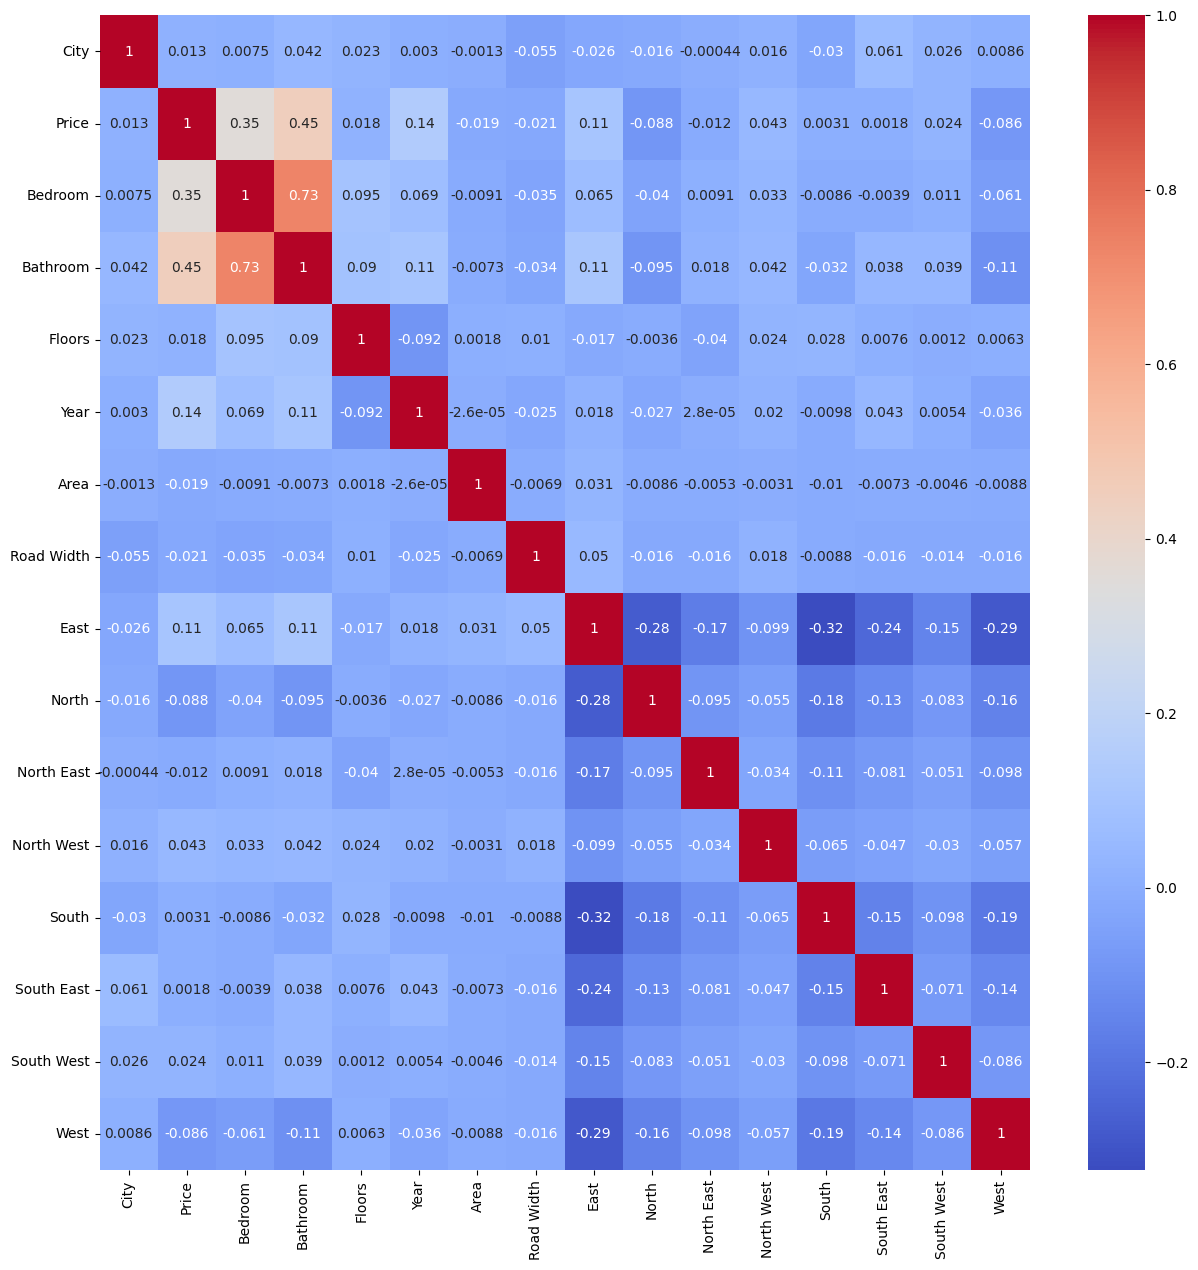

In [163]:
plt.figure(figsize=(15,15))  # Set figure size
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")  # Use a colormap for better visualization
plt.show()

## 3.1 Linear Regression

In [155]:
model = LinearRegression()

model.fit(x_train, y_train)

model.score(x_test, y_test)



0.2665023179937148

## 3.2 Random Forest

In [156]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(x_train, y_train)

model.score(x_test, y_test)



0.27315273477231705

## 3.3 XGBoost

In [157]:
import xgboost

model = xgboost.XGBRegressor(n_estimators=100, random_state=42)

model.fit(x_train, y_train)

model.score(x_test, y_test)





ModuleNotFoundError: No module named 'xgboost'